In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F


from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')


In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,x,y):
        my_loss = torch.mean(torch.abs((x - y)/y))
        return  my_loss


In [4]:
def main():
    forecast_length = 28
    backcast_length = 48
    # backcast_length = forecast_length*7
    batch_size = 32  # greater than 4 for viz

    electric = pd.read_csv('data/SEASON/output_avg - Copy (3).csv', index_col=0, parse_dates=True)

    print(electric.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK,NBeatsNet.SEASONALITY_BLOCK,NBeatsNet.TREND_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        # nb_blocks_per_stack=4,
        hidden_layer_units = 64,
        thetas_dim=(8,8,3),
        share_weights_in_stack=True
    )
    # net = torch.load("model(wu).pth")
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())
    # optimiser = optim.Adam(lr=0.002, params=net.parameters())


    grad_step = 0
    # best_state_dict = None
    # best_loss = float('inf')
    for epoch in range(1200):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            A=CustomLoss()
            # loss = A(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        B=CustomLoss()
        # test_loss = B(forecast, torch.tensor(y_test, dtype=torch.float).to(net.device)).item()
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)

            # if test_loss < best_loss:
            #     best_loss = test_loss
            #     # best_state_dict = nbeats.state_dict()
            #     best_state_dict = net.state_dict()


            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    B = forecast.flatten()
    C= B * norm_constant
    NC = C.detach().numpy()
    NNC = NC.tolist()
    Text=NNC[len(NNC)-28::]
    print('Text',Text)

    # avg=[]
    # # 当len（forecast）< forecast_length
    # if  forecast_length>len(forecast):
    #    for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:6])
    #          avg.append(N)
    #          pass
    #
    #       elif forecast_length-1>=i>len(forecast)-1:
    #          avg.append(np.mean(NNC[i:forecast_length * i + 1:6]))
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #    pass

    # 当len（forecast）= forecast_length
    # elif forecast_length == len(forecast):
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i :4 * i + 1 : 6])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #     pass
    #
    # # 当len（forecast）> forecast_length
    # else:
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=forecast_length-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:6])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast)>i>forecast_length-1:
    #          t = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * t : len(NNC) - (len(forecast)-i) * forecast_length + 1 : 6]))
    #          pass
    #
    #       # 在这里下端触底了
    #       elif len(forecast) + forecast_length - 2 > i >= len(forecast)-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC) - 1 : 6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #     pass

    # print('avg',avg)
    # print(type(avg))
    # print('len(avg)',len(avg))
    #
    # Text=avg[len(avg)-30::]
    # print('Text',Text)


    TRU = electric[len(electric)-28::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU),type(TRU))






    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - Text[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - Text[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    torch.save(net,'STL_N-BEATS(simple13).pth')









if __name__ == '__main__':
    main()

               avg_load
date                   
2006-01-04  8060.226216
2006-01-05  8081.884756
2006-01-06  8292.417466
2006-01-07  7620.753992
2006-01-08  7552.765243
272
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)


TypeError: relu(): argument 'input' (position 1) must be Tensor, not Linear

               avg_load
date                   
2006-01-04  8060.226216
2006-01-05  8081.884756
2006-01-06  8292.417466
2006-01-07  7620.753992
2006-01-08  7552.765243
272
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=48, forecast_length=28, share_thetas=False) at @2402940281480
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=48, forecast_length=28, share_thetas=False) at @2402940281480
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=48, forecast_length=28, share_thetas=False) at @2402940281480
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=28, backcast_length=48, forecast_length=28, share_thetas=True) at @2402916094216
     | -- SeasonalityBlock(units=64, thetas_dim=28, backcast_length=48, forecast_length=28, share_thetas=True) at @2402916094216
     | -- SeasonalityBlock(units=64, thetas_dim=28, backcast_length=48,

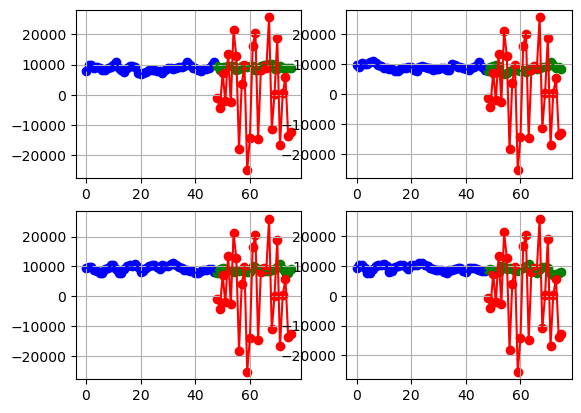

epoch = 0000, grad_step = 000006, tr_loss (epoch) = 1433.993, te_loss (epoch) = 1370.303


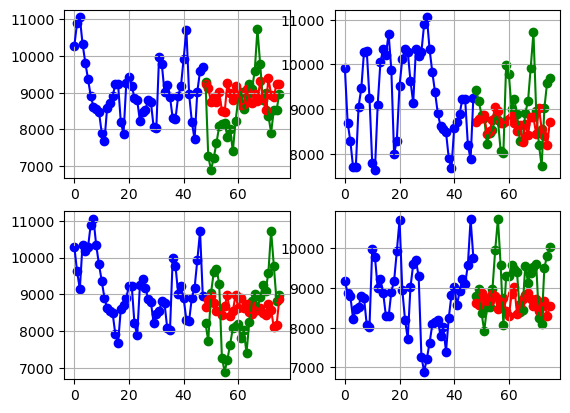

epoch = 0100, grad_step = 000606, tr_loss (epoch) = 72.442, te_loss (epoch) = 78.920


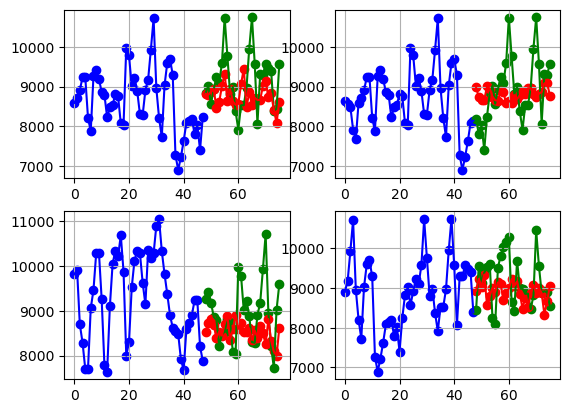

epoch = 0200, grad_step = 001206, tr_loss (epoch) = 70.007, te_loss (epoch) = 78.311


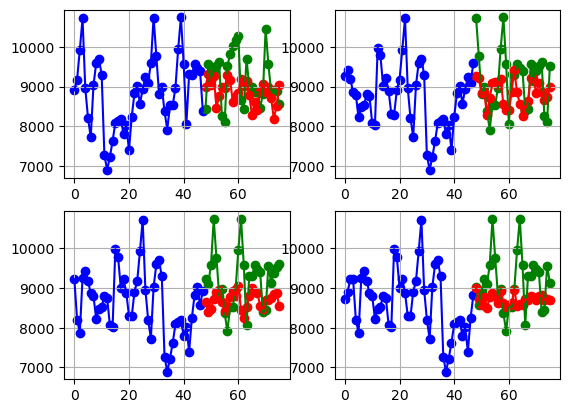

epoch = 0300, grad_step = 001806, tr_loss (epoch) = 67.866, te_loss (epoch) = 78.463


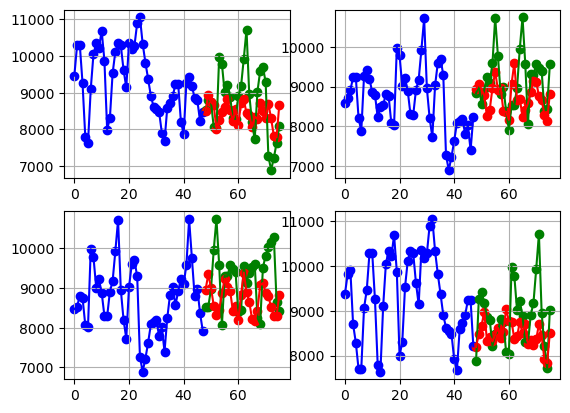

epoch = 0400, grad_step = 002406, tr_loss (epoch) = 66.326, te_loss (epoch) = 78.200


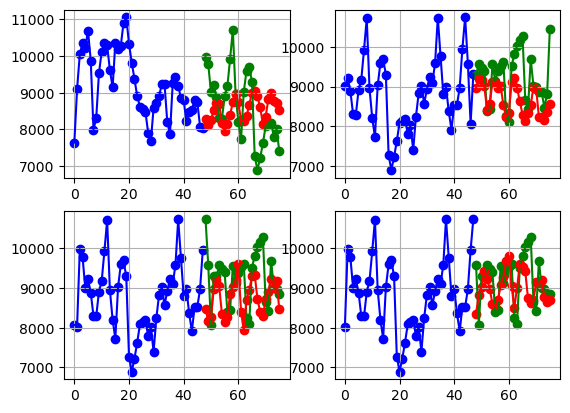

epoch = 0500, grad_step = 003006, tr_loss (epoch) = 64.811, te_loss (epoch) = 77.611


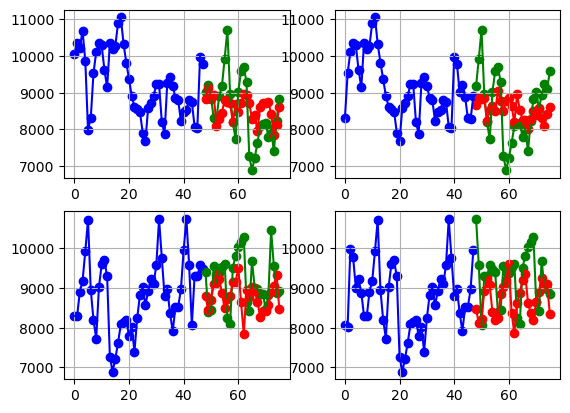

epoch = 0600, grad_step = 003606, tr_loss (epoch) = 63.330, te_loss (epoch) = 77.699


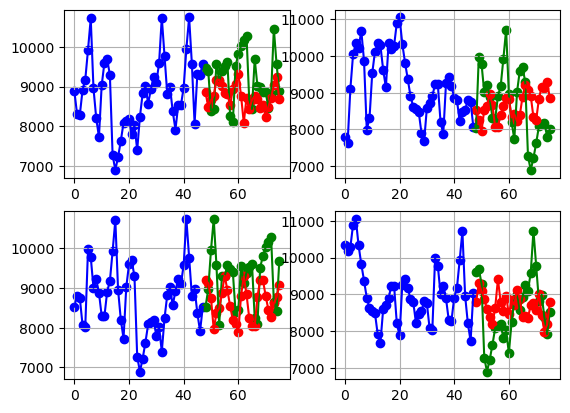

epoch = 0700, grad_step = 004206, tr_loss (epoch) = 61.901, te_loss (epoch) = 77.328


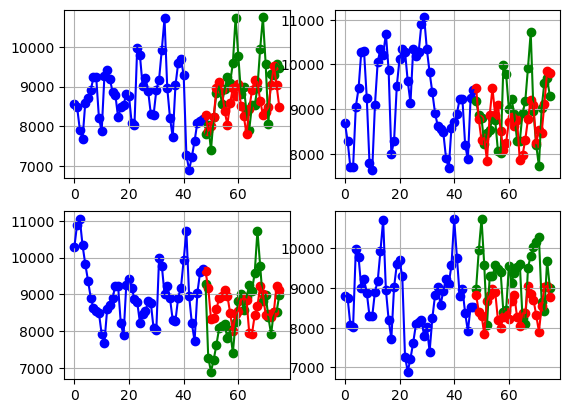

epoch = 0800, grad_step = 004806, tr_loss (epoch) = 60.793, te_loss (epoch) = 76.964


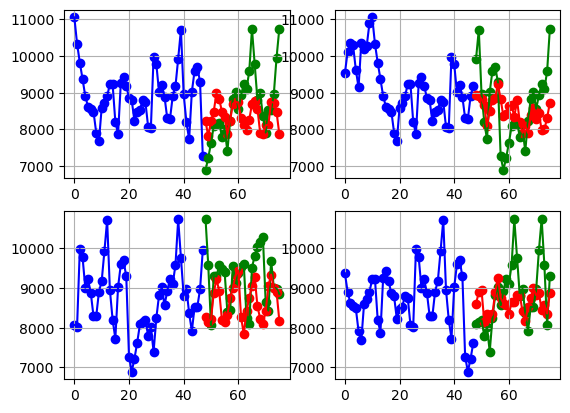

epoch = 0900, grad_step = 005406, tr_loss (epoch) = 59.769, te_loss (epoch) = 76.888


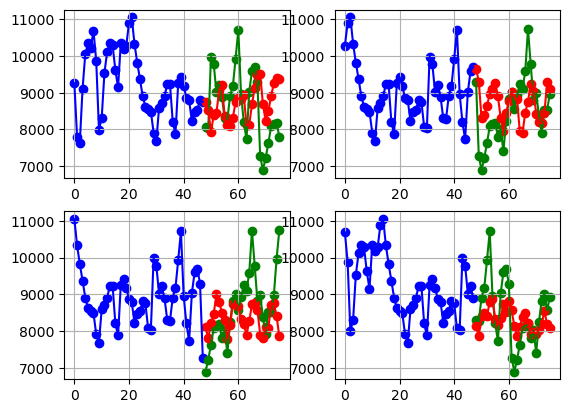

epoch = 1000, grad_step = 006006, tr_loss (epoch) = 59.217, te_loss (epoch) = 76.801


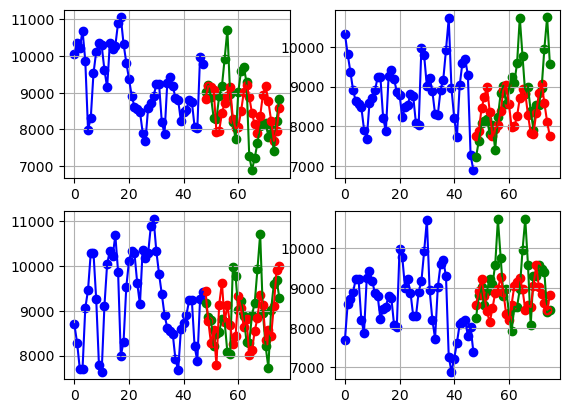

epoch = 1100, grad_step = 006606, tr_loss (epoch) = 58.477, te_loss (epoch) = 76.616
Text [9040.5283203125, 9072.310546875, 9248.9296875, 9256.3466796875, 8870.04296875, 8805.126953125, 8789.919921875, 8859.765625, 9356.783203125, 9268.5771484375, 9039.19140625, 8828.9248046875, 8691.09765625, 8708.6884765625, 8670.8515625, 9000.5625, 8850.826171875, 8656.7626953125, 8613.01953125, 8393.609375, 8599.310546875, 8681.1552734375, 8692.3212890625, 9027.2177734375, 8569.78515625, 8535.1953125, 8455.6552734375, 8607.3125]
TRU [ 9565.073542  9140.978958  9389.424375  9524.447708  9615.264375
  8251.320625  8105.730625  9514.851667  9818.613333 10028.63646
 10174.005    10284.14188   8661.1725    8433.374167  9693.409375
  9010.57875   8989.191042  8855.477292  8862.195208  8468.077292
  8813.953542 10459.50021   9559.9325    8881.44625   8922.066875
  8893.76375   8552.212292  8223.16125 ]
TRU 28
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
28 天总共预测电量的mape的平均值
mape : 0.05
mape % : 5.13 %
-

RuntimeError: mat1 and mat2 shapes cannot be multiplied (69x48 and 60x64)

In [18]:


from numexpr import evaluate


def main():
    forecast_length = 28
    backcast_length = 48
    # backcast_length = forecast_length*7
    batch_size = 48  # greater than 4 for viz

    electric = pd.read_csv('data/SEASON/output_avg - Copy (3).csv', index_col=0, parse_dates=True)

    print(electric.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=( NBeatsNet.GENERIC_BLOCK,NBeatsNet.SEASONALITY_BLOCK,NBeatsNet.TREND_BLOCK),
        # cst
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units = 64,
        thetas_dim=(2,8,3),
        share_weights_in_stack=True
    )
    # net = torch.load("model(wu).pth")
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())
    # optimiser = optim.Adam(lr=0.002, params=net.parameters())


    grad_step = 0
    best_state_dict = None
    best_loss = 100000
    # best_loss = 0.01
    for epoch in range(1200):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            A=CustomLoss()
            loss = A(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            # loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        B=CustomLoss()
        test_loss = B(forecast, torch.tensor(y_test, dtype=torch.float).to(net.device)).item()
        # test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()

        if test_loss < best_loss:
            best_loss = test_loss
            best_state_dict = net


        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()


            with torch.no_grad():
                save(net, optimiser, grad_step)




            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')


    torch.save(net.state_dict(),'STL_N-BEATS(normal2).pth')
    torch.save(best_state_dict,'STL_N-BEATS(min2).pth')


    B = forecast.flatten()
    C= B * norm_constant
    NC = C.detach().numpy()
    NNC = NC.tolist()
    Text=NNC[len(NNC)-28::]
    print('Text',Text)

    # avg=[]
    # # 当len（forecast）< forecast_length
    # if  forecast_length>len(forecast):
    #    for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:6])
    #          avg.append(N)
    #          pass
    #
    #       elif forecast_length-1>=i>len(forecast)-1:
    #          avg.append(np.mean(NNC[i:forecast_length * i + 1:6]))
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #    pass

    # 当len（forecast）= forecast_length
    # elif forecast_length == len(forecast):
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i :4 * i + 1 : 6])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #     pass
    #
    # # 当len（forecast）> forecast_length
    # else:
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=forecast_length-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:6])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast)>i>forecast_length-1:
    #          t = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * t : len(NNC) - (len(forecast)-i) * forecast_length + 1 : 6]))
    #          pass
    #
    #       # 在这里下端触底了
    #       elif len(forecast) + forecast_length - 2 > i >= len(forecast)-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC) - 1 : 6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #     pass

    # print('avg',avg)
    # print(type(avg))
    # print('len(avg)',len(avg))
    #
    # Text=avg[len(avg)-30::]
    # print('Text',Text)


    TRU = electric[len(electric)-28::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU),type(TRU))






    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - Text[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - Text[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    # torch.save(best_state_dict,'STL_N-BEATS(simple8).pth')



    print('--------------------------------------------------------------------------------------------------')


    print('model min2')
    net = torch.load('STL_N-BEATS(min2).pth')
    # net.load_state_dict(state_dict)
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    A = forecast.flatten()
    CC= A * norm_constant
    NC = CC.detach().numpy()
    NNCC = NC.tolist()
    TextC=NNCC[len(NNC)-28::]

    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - TextC[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - TextC[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    print('--------------------------------------------------------------------------------------------------')
    print('model normal1')

    net = torch.load('STL_N-BEATS(normal1).pth')

    # net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    A = forecast.flatten()
    CC= A * norm_constant
    NC = CC.detach().numpy()
    NNCC = NC.tolist()
    TextC=NNCC[len(NNC)-28::]
    # print('Text',TextC)


    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - TextC[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - TextC[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)



if __name__ == '__main__':
    main()